In [2]:
#purpose is to take HST images and identify extended sources (HH objects in our case)

#just to check python version - should be 3.7.4
from platform import python_version
print(python_version())

#importing astro libraries
from astropy.io import fits
from astropy.convolution import convolve, Gaussian2DKernel, Box2DKernel
from astropy.nddata import Cutout2D
from astropy.wcs import WCS

#importing general tools
import glob
import itertools
import matplotlib 
matplotlib.use('Agg') #invokved b/c just plain matplotlib was insufficient
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

%matplotlib inline

3.8.5


# Gather some data, convert units!

In [44]:
# #finding the path to every fits images in a directory
def im_name_finder(path, file_type):
    #Using glob (it's a unix command similar to ls)
    #WARNING: using recursive=True...depending how many images you use this could be very slow, it's recommended not to have too many subfolders
    #if needed, some example code is commented towards the latter half of this code that could help make an alternative
    all_names = glob.glob(path, recursive=True)

    #IMPORTANT: Using "fit" here because it is inclusive of both fits and FIT...some files end in "FIT" and need to be included
    #can edit this accordingly or edit your file names
    #using s.lower() includes uppercase extensions like FIT
    im_names = [s for s in all_names if 'fit' in s.lower()]

    return im_names

# #EX: grabbing all the fits image paths in a directory, #so they can be looped through and their data opened
# #set your path to some directory with images # (the images can be in subdirectories)
#the spitzer images
path = 'nonlin_656shifted_RFe2p0RH17p5start2500end400Tinc50fluxlim0p1e-17_A_V.fits' # #using ** will grab all files even in subdirectories WARNING takes longer
filenames = im_name_finder(path, 'fit') #im_finder is basically glob.glob
filenames = [i.replace('\\', '/') for i in filenames]
# im_names_spitz.remove('../../n1333_photometry_ds9.bck.dir/Frame20/n1333_band2_300_300_residual_hdrswap.fits')

#opening data and headers
hdu_list = [fits.open(i) for i in filenames]
hdu_data_list = []
hdu_data_list.append(hdu_list[0][0].data)

# Next, try to identify some HH objects...
This is tricky. We'll need photutils, segmentation maps, a cutout of the image, maybe smoothing the image by convolution...

In [ ]:
#installing any needed packages if you want to do photometry and segmentation (we do!)
# !conda install --yes --prefix {sys.prefix} -c conda-forge photutils

In [11]:
from photutils.background import Background2D, MedianBackground
from photutils.segmentation import detect_threshold

from astropy.convolution import Gaussian2DKernel, convolve
from astropy.stats import gaussian_fwhm_to_sigma
from photutils.segmentation import detect_threshold, detect_sources
from photutils.segmentation import deblend_sources

from photutils.segmentation import SourceCatalog

In [67]:
#this set of cells shows how to apply our procedure to an entire large mosaic image

#first step is background subtraction, thresholding
#I've found better to use no background subtracting, but the option is there if you like

#please see https://photutils.readthedocs.io/en/stable/segmentation.html for references and documentation
#the idea is to use the photutils package and/or segmentation maps to distinguish a bright source from background or noise

from photutils.background import Background2D, MedianBackground
from photutils.segmentation import detect_threshold
bkg_estimator = MedianBackground()

bkg_list = []
data_bkg_subtracted = []
threshold_list = []
nsig = 5. #IMPORTANT, should change this...
for data in hdu_data_list:
#     data_cut = np.array(hdu_data_list[-1][2700:3000, 4500:4900])
    data_nonan = data
    data_nonan[np.isnan(data)] = 0
#     bkg = Background2D(data_cut, (50, 50), filter_size=(3, 3), bkg_estimator=bkg_estimator)
#     bkg_list.append(bkg)
#     threshold_list.append(2. * bkg.background_rms )  # above the background
    threshold_list = detect_threshold(data_nonan, nsigma=nsig)
    data_bkg_subtracted.append( data_nonan ) # subtract the background
    

In [68]:
#next we apply segmentation maps
from astropy.convolution import Gaussian2DKernel, convolve
from astropy.stats import gaussian_fwhm_to_sigma
from photutils.segmentation import detect_threshold, detect_sources
from photutils.segmentation import deblend_sources

sigma = nsig * gaussian_fwhm_to_sigma  # FWHM = whatever number is in front
kernel = Gaussian2DKernel(sigma, x_size=nsig, y_size=nsig)
kernel.normalize()

npixels = 100
segm_deblend_list = []
# convolved_list = [] #if you would like to convolve data
for (data,threshold) in zip(data_bkg_subtracted, threshold_list):
#     convolved_list.append( convolve(data, kernel, normalize_kernel=True) )
    segm = detect_sources(data, threshold, npixels=npixels)
    segm_deblend_list.append( deblend_sources(data, segm, npixels=npixels) )

In [69]:
#locating and outputting centroids for convenience or checking if needed
cat_list = []
for (data, segm_deblend) in zip(data_bkg_subtracted, segm_deblend_list): 
    cat_list.append( SourceCatalog(data, segm_deblend) )
    tbl = cat_list[0].to_table()
    tbl['xcentroid'].info.format = '.2f'  # optional format
    tbl['ycentroid'].info.format = '.2f'
    tbl['kron_flux'].info.format = '.2f'
    print(tbl)


label xcentroid ycentroid ... segment_fluxerr kron_flux kron_fluxerr
                          ...                                       
----- --------- --------- ... --------------- --------- ------------
    1     13.71     19.00 ...             nan   1395.02          nan
    2    191.78     32.77 ...             nan    878.58          nan
    3    149.64    247.25 ...             nan    780.65          nan
    4    377.91    281.60 ...             nan   1091.91          nan
    5    391.60    353.24 ...             nan   2302.40          nan
    6     70.21    412.68 ...             nan   1785.48          nan
    7    199.93    411.50 ...             nan    884.01          nan
    8     94.12    414.93 ...             nan    853.93          nan
    9    136.26    419.21 ...             nan   2359.91          nan
   10    329.39    429.40 ...             nan   1414.00          nan
  ...       ...       ... ...             ...       ...          ...
   85    198.46    543.31 ...     

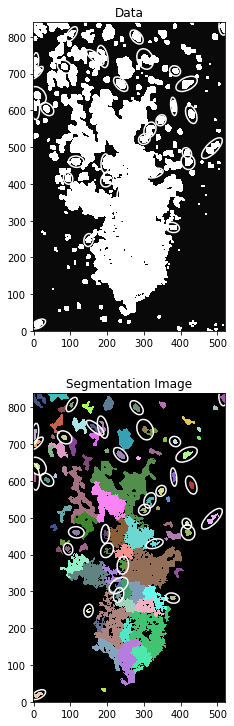

In [70]:
#finally we plot the image, the segments, and also show you can automatically produce naive apertures
# from astropy.visualization import simple_norm

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.set_title('Data')
ax2.set_title('Segmentation Image')

img_choice = [0] #enabling you to choose your image, should be adjustable to needs
for i in img_choice:
    apertures = cat_list[i].kron_aperture
    patches = []
    
    #plotting apertures
    for aperture in apertures:
        #filtering apertures by size, could do it by flux, called aperture.kron_flux
        if aperture is not None and np.pi*aperture.a*aperture.b > 500 and np.pi*aperture.a*aperture.b < 2000:
            aperture.plot(axes=ax1, color='white', lw=1.5)
            aperture.plot(axes=ax2, color='white', lw=1.5)
            patches.append(aperture._to_patch())
    
    #plotting the thresholded data
#     norm = simple_norm(data_bkg_subtracted[i], 'sqrt')
    ax1.imshow(data_bkg_subtracted[i], origin='lower', cmap='Greys_r', vmin=-1e-18, vmax=3e-17)
    
    #plotting the associated segmentation map
    cmap = segm_deblend_list[i].make_cmap(seed=123)
    ax2.imshow(segm_deblend_list[i], origin='lower', cmap=cmap, interpolation='nearest')

In [ ]:
#trying to only show mask

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.set_title('Data')
ax2.set_title('Segmentation Image')

norm = simple_norm(data_bkg_subtracted[i], 'sqrt')
ax1.imshow(data_bkg_subtracted[i], origin='lower', cmap='Greys_r', vmin=-1e-18, vmax=3e-17)

cmap = segm_deblend_list[i].make_cmap(seed=123)
ax2.imshow(segm_deblend_list[i], origin='lower', cmap=cmap, interpolation='nearest')